### CONFIGURATION

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn

In [3]:
#CHROM SLICING
minChromFrac = 0#17.443476
maxChromFrac = 26#17.491846

#minChromFrac = 17.689695
#maxChromFrac = 17.73896

In [6]:
# BED FILE
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"

# COMBINED VCF CONFIG
VCF_SAMPLE = "12878"
VCF_PATH = "/Users/peterpriestley/hmf/analyses/NA12878vsNA12878/Oct28/"
#VCF_PATH = "/Users/peterpriestley/hmf/analyses/fpfilterAnalysis/"
VCF_FILE_NAME = VCF_SAMPLE + "R_"+ VCF_SAMPLE + "T_merged_somatics.vcf"
#VCF_FILE_NAME = "fpNA12878vsNA12878NORMMELT.vcf"
SAMPLE_NAMES = {VCF_SAMPLE + 'T.mutect':'mutect', \
                VCF_SAMPLE + 'T.freebayes':'freebayes', \
                'TUMOR.strelka':'strelka', \
                'TUMOR.varscan':'varscan'}

#MELT PARAMS
#VCF_FILE_NAME = "12878R_12878T_merged_somatics_annotated_melted.vcf"
#SAMPLE_NAMES = {'12878T':'melted'}


### Functions

In [7]:
def filterByChromFrac(df):
    return df[(df.chromFrac > minChromFrac)&(df.chromFrac < maxChromFrac)]

In [8]:
def calculateTruth(df,dfTruth):
    df = pd.merge(df,dfTruth,how='left', left_index=True,right_index=True,suffixes=('', '_Truth'))
    df['hasTP'] = False
    df['hasFP'] = False
    for columnName in list(df):
        if columnName.endswith('allele'):
            df['hasTP'] = (df['hasTP']) | ((df[columnName[:-6]+'indelDiff'] == df['truth_indelDiff']) \
                    & (~pd.isnull(df['truth_indelDiff']) & (df['variantType'] == 'INDEL'))) |((df[columnName] == df['truth_allele']) \
                    & (df['variantType'] == 'SNP'))
            df['hasFP'] = (df['hasFP']) | ((df[columnName[:-6]+'indelDiff'] != df['truth_indelDiff']) \
                    & (df['variantType'] == 'INDEL') & (df[columnName[:-6]+'indelDiff'] != '')) |((df[columnName] != df['truth_allele']) \
                    & (df['variantType'] == 'SNP') & (df[columnName] != ''))
    df['Truth'] = (df['hasTP']) &  (df['hasFP'] == False)
    return df

In [9]:
def calcuatePrecisionSensivityMatrix(df):
    outputdata = []
    for columnName in list(df):
        if columnName.endswith('allele') & ~columnName.endswith('_allele'):
            myCaller = columnName[:-6]
            variantTypes = df[(df[myCaller+'allele'] != '')].variantType.unique()
            for variantType in variantTypes:
                truePositives = len(df[(df[myCaller+'allele'] != '') & (df['Truth'] == True) &(df['variantType'] == variantType)])
                positives = len(df[(df[myCaller+'allele'] != '')&(df['variantType'] == variantType)])
                truthSet = 0
                falseNegatives = truthSet - truePositives
                if positives > 0:
                    outputdata.append([variantType, myCaller, truthSet,truePositives,positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),0])
    
    outputDF = pd.DataFrame(outputdata)
    outputDF.columns = (['variantType','caller','truthSet','truePositives','falsePositives','falseNegatives','precision','sensitivity'])
    return outputDF.sort_values(['variantType','caller'])

<h3> Load VCFs and Prepare DF

In [10]:
## LOAD BED
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
cum_sum =0
for row in bed:
    cum_sum += -int(row[1]) + int(row[2])
print cum_sum

reading BED file
Bed File Loaded
2529164928


In [11]:
# LOAD SAMPLE VCF + match to truth set
#sampleBed = copy.deepcopy(bed)
dfProd = aVCF.loadVaraintsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,True)#, True,sampleBed)
dfProd = filterByChromFrac(dfProd)
dfProd = dfProd.set_index(['chrom','pos'])

reading vcf file: 12878R_12878T_merged_somatics.vcf
Number variants loaded: 42839


In [12]:
dfProd['dbSNP'] = (dfProd['id'].str.contains('rs'))
dfProd['COSMIC'] = (dfProd['id'].str.contains('COSM'))

### PRECISION + SENSITIVITY|

In [13]:
#PRECISION + SENSITIVITY by caller - PROD
dfProd['Truth'] = False
outputDF = calcuatePrecisionSensivityMatrix(dfProd)#[dfProd.dbSNP==True])
outputDF

,variantType,caller,truthSet,truePositives,falsePositives,falseNegatives,precision,sensitivity
6,INDEL,freebayes,0,0,7364,0,0.0,0
1,INDEL,strelka,0,0,340,0,0.0,0
3,INDEL,varscan,0,0,3480,0,0.0,0
5,SNP,freebayes,0,0,9176,0,0.0,0
4,SNP,mutect,0,0,11496,0,0.0,0
0,SNP,strelka,0,0,9512,0,0.0,0
2,SNP,varscan,0,0,5959,0,0.0,0


In [176]:
dftemp = dfProd.reset_index()
pd.pivot_table(dftemp, values='pos', index=['variantType', 'vennSegment'], columns=['dbSNP'], aggfunc='count')

dbSNP                                                  False   True 
variantType vennSegment                                             
INDEL       filterInvarscan-freebayes                   16.0     NaN
            freebayes                                 5569.0     NaN
            strelka                                     15.0     3.0
            strelka-freebayes                            6.0     NaN
            strelka-varscan                              NaN     1.0
            strelka-varscan-freebayes                    6.0     NaN
            varscan                                   1122.0  1219.0
            varscan-freebayes                          809.0     1.0
SNP         Intersection                                24.0    14.0
            filterInvarscan-freebayes                   86.0    58.0
            filterInvarscan-freebayes-mutect             1.0     3.0
            filterInvarscan-mutect                       8.0     1.0
            freebayes                                 1840.0  1362.0
            freebayes-mutect                            98.0   106.0
            mutect                                    1542.0   507.0
            strelka                                   2671.0   861.0
            strelka-filterInvarscan                      5.0     NaN
            strelka-filterInvarscan-freebayes            4.0     NaN
            strelka-filterInvarscan-freebayes-mutect     1.0     NaN
            strelka-filterInvarscan-mutect               1.0     1.0
            strelka-freebayes                           52.0    49.0
            strelka-freebayes-mutect                     9.0    11.0
            strelka-mutect                             354.0    87.0
            strelka-varscan                             61.0    49.0
            strelka-varscan-freebayes                   38.0    29.0
            strelka-varscan-mutect                      37.0    11.0
            varscan                                    979.0   732.0
            varscan-freebayes                          276.0   275.0
            varscan-freebayes-mutect                    50.0    49.0
            varscan-mutect                              17.0    30.0

In [14]:
#dftemp = dfProd.reset_index()
#pd.set_option('display.max_rows', 500)
#pd.pivot_table(dftemp, values='pos', index=['filter'], columns=['variantType'], aggfunc='count').sort_values("SNP",ascending=False)

In [166]:
dfProd[(dfProd['variantType']== "INDEL")&(dfProd['Truth']== True)&(dfProd['filter']== "PASS")].head(10)

,,chromPos,chromFrac,id,ref,vennSegment,numCallers,variantType,variantSubType,filter,meltedallele,meltedAF,meltedDP,meltedQS,meltedSGT,meltedindelDiff,meltedindelPos,patientName,dbSNP,COSMIC,Truth
chrom,pos,,,,,,,,,,,,,,,,,,,,


In [ ]:
#PRECISION + SENSITIVITY by caller - SLICE
outputDF = calcuatePrecisionSensivityMatrix(dfSlice)
outputDF

# False Negative Analysis

In [ ]:
pd.options.display.max_rows = 200
caller = "varscan"
dfProd[(dfProd.Truth == True) &(dfProd[caller+'allele'] != '') & (dfProd.variantType == 'INDEL')][['ref',caller+'indelDiff',caller+'QS',caller+'AF','numCallers']]

In [ ]:
dfSlice[(dfSlice['Truth'] == True) & (dfSlice['freebayesallele'] != '') & (dfSlice.variantType == 'INDEL')]

In [ ]:
unfilteredBed = copy.deepcopy(bed)

In [ ]:
# SETTINGS
myCaller = 'varscan'
UNFILTERED_VCF_PATH = "/Users/peterpriestley/hmf/70-30slice/"
if myCaller == 'varscan':
    UNFILTERED_VCF_FILE_NAME = "varscan.snp.vcf"
    UNFILTERED_SAMPLE_NAMES = {"TUMOR":myCaller}
elif myCaller == 'freebayes':
    UNFILTERED_VCF_FILE_NAME = "freebayes.somatic.vcf"
    UNFILTERED_SAMPLE_NAMES = {'CPCT11111111T':myCaller}  
elif myCaller == 'strelka':
    UNFILTERED_VCF_FILE_NAME = "/strelka/results/all.somatic.snvs.vcf"
    UNFILTERED_SAMPLE_NAMES = {"TUMOR":myCaller}
elif myCaller == 'mutect':
    UNFILTERED_VCF_FILE_NAME = "mutect.vcf"
    UNFILTERED_SAMPLE_NAMES = {'CPCT11111111T':myCaller}


dfUnfiltered = aVCF.loadVaraintsFromVCF(UNFILTERED_VCF_PATH,UNFILTERED_VCF_FILE_NAME,UNFILTERED_SAMPLE_NAMES,VCF_SAMPLE,False,True,unfilteredBed)
dfUnfiltered['Truth']=dfUnfiltered.chromPos.isin(dfTruth['chromPos']) 
dfUnfiltered = dfUnfiltered[(dfUnfiltered.chromFrac > minChromFrac)&(dfUnfiltered.chromFrac < maxChromFrac)]

In [ ]:
dfTruth['inUnfiltered'+myCaller]=dfTruth.chromPos.isin(dfUnfiltered[dfUnfiltered[myCaller+'allele'] != '']['chromPos'])
dfTruth['inSlice']=dfTruth.chromPos.isin(dfSlice['chromPos'])

In [ ]:
#False Positives - pre-somatic
dfTruth[['inSlice','pos','inUnfiltered'+myCaller,'variantType']].groupby(['variantType','inUnfiltered'+myCaller]).agg('count')


In [ ]:
dfUnfiltered['inSlice'+myCaller]=dfUnfiltered.chromPos.isin(dfSlice[dfSlice[myCaller+'allele'] != '']['chromPos'])
dfUnfiltered['inSlice']=dfUnfiltered.chromPos.isin(dfSlice['chromPos'])

In [ ]:
dfUnfiltered[['inSlice'+myCaller,'pos','Truth','variantType','filter']].groupby(['variantType','inSlice'+myCaller,'Truth','filter']).agg('count')


In [ ]:

dfUnfiltered[(dfUnfiltered['Truth'] == True)&
            (dfUnfiltered['inSlice'+myCaller] == True)& 
             (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['filter'] != 'PETE')]['pos']

In [ ]:
#FALSE NEGATIVES IN UNFILTERED
dfUnfiltered[(dfUnfiltered['inSlice'+myCaller] == False)& 
             (dfUnfiltered[myCaller+'somaticGT'] != '2')&
             (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['filter'] != 'str10')].sort_values([myCaller+'QS'],ascending=False)

In [ ]:
dfSlice[dfSlice.pos>'37577400'].head(10)

In [ ]:
#FALSE POSITIVES`
dfUnfiltered[(dfUnfiltered['inSlice'+myCaller] == True) & (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['Truth'] == False)].sort_values([myCaller+'QS'],ascending=False)

<h3> SNP

In [29]:
snpdf = dfProd[(dfProd.variantType == 'INDEL')]

In [ ]:
snpdf[['Truth','pos']].groupby(['Truth']).agg('count')

In [ ]:
pd.pivot_table(snpdf, values='pos', index=['numCallers'], columns=['Truth'], aggfunc='count')

In [ ]:
vn.venn([snpdf[snpdf.mutectallele != '']['chromPos'], \
         snpdf[snpdf.strelkaallele != '']['chromPos'], \
        snpdf[snpdf.freebayesallele != '']['chromPos'], \
        snpdf[snpdf.varscanallele != '']['chromPos'] \
        ],['mutect','strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Indel Venn

In [ ]:
indeldf= dfProd[(dfProd.variantType == 'SNP')]

In [ ]:
pd.pivot_table(indeldf, values='pos', index=['numCallers'], columns=['Truth'], aggfunc='count')

In [ ]:
vn.venn([indeldf[indeldf.strelkaallele != '']['chromPos'], \
        indeldf[indeldf.freebayesallele != '']['chromPos'], \
        indeldf[indeldf.varscanallele != '']['chromPos'] \
        ],['strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Read Depth

In [ ]:
for columnName in list(df):
    if columnName.endswith('allelicFreq'):
        df[df[columnName] != ''].hist(column=columnName,by="Truth",bins=40,figsize=(10,5))
        

In [ ]:
df[df.freebayesreadDepth != ''].hist(column="freebayesallelicFreq",by="Truth",bins=30)

In [ ]:
# INDELS BY CALLER BY TRUTH
caller = 'freebayes'
truths = indeldf.Truth.unique()
for truth in truths:
    ser = indeldf[(indeldf.Truth == truth) &(indeldf[caller+'allele'] != '')][caller + 'QS']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=caller+" INDEL "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=caller+" Qual Score CDF - INDELS",figsize=[15,6], xlim=[0,100],ylim=[0,1])

truths = snpdf.Truth.unique()
for truth in truths:
    ser = snpdf[(snpdf.Truth == truth) &(snpdf[caller+'allele'] != '')][caller + 'QS']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=caller+" SNP "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=caller+"Qual Score CDF",figsize=[15,6],xlim=[0,100],ylim=[0,1])

<h3> Allelic Depth

In [160]:
snpdf = dfProd[(dfProd.variantType == 'SNP')&(dfProd['filter'] == 'VarFreq')]
len(snpdf)

0

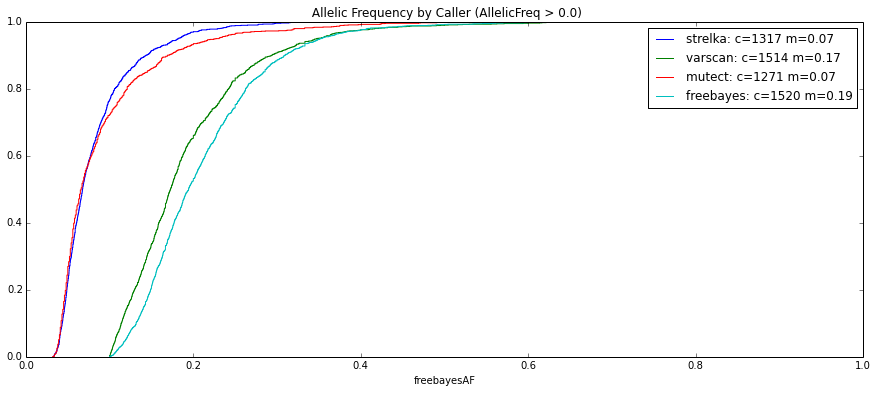

In [28]:
#snpdf = dfProd[(dfProd.variantType == 'SNP')&(dfProd['filter'] == 'VarFreq')]
snpdf = dfProd[(dfProd.variantType == 'SNP')&(dfProd.numCallers == 2)]
#Alllele Freq By Caller
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-6] + 'AF'] > 0.0)][columnName[:-6] + 'AF']
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[15,6],xlim=[0,1])

In [ ]:
# BY CALLER BY TRUTH
truths = snpdf.Truth.unique()
for truth in truths:
    for columnName in list(snpdf):
        if columnName.endswith('allele'):
            ser = snpdf[(snpdf.Truth == truth) &(snpdf[columnName] != '')][columnName[:-6] + 'allelicFreq']
            ser = ser.sort_values()
            #ser[len(ser)] = ser.iloc[-1]
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+" "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller and Truth",figsize=[15,6])

In [ ]:
#  BY VENN SEGMENT - Single Caller - FALSE POSITIVES
myCaller = 'freebayes'
vennSegments = snpdf[(snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False)].vennSegment.unique()
for vennSegment in vennSegments:
    ser = snpdf[(snpdf.vennSegment == vennSegment) & (snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False) ][myCaller+'allelicFreq']
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=vennSegment+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=myCaller+" FP by Venn Segment",figsize=[15,6])

### Allelic Depth Scatter Plot

In [ ]:
caller1 = 'varscan'
caller2 = 'strelka'
tempdf = df[(df[caller1+'allele']!='')&(df[caller2+'allele']!='')]
tempdf.head()
tempdf.plot.scatter(caller1+'allelicFreq',caller2+'allelicFreq' \
                        ,figsize=[6,6] \
                        ,title="Comparison of "+caller1+" and "+caller2+" Allelic Frequency" \
                        ,xlim=[0,1],ylim=[0,1])

<h3> RAINBOW CHARTS

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

<h3> Overlapping Analysis

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
sorteddf = df.sort(['chromFrac'], ascending=1)
sorteddf['nextRef'] = sorteddf['ref'].shift(-2)
sorteddf['nextPos'] = sorteddf['pos'].shift(-2)
sorteddf['nextChrom'] = sorteddf['chrom'].shift(-2)
sorteddf['nextVT'] = sorteddf['variantType'].shift(-2)
sorteddf['nextAlleleTumor1'] = sorteddf['alleleTumor1'].shift(-2)
sorteddf['nextAlleleTumor2'] = sorteddf['alleleTumor2'].shift(-2)
sorteddf['nextVennSegment'] = sorteddf['vennSegment'].shift(-2)
sorteddf['lengthRef'] = sorteddf['ref'].str.len()
sorteddf['Dist2Next'] = -sorteddf['pos'].astype(int).diff(-2)

overlapdf = sorteddf[(sorteddf['lengthRef']+0>sorteddf['Dist2Next']) & (sorteddf['Dist2Next']>0)]
overlapdf.head(20)
'''

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
filtereddf = overlapdf[(~overlapdf.vennSegment.isin(['freebayes','varscan','strelka1'])) \
                       & (overlapdf.vennSegment.str.contains('varscan')) \
                       #& (~overlapdf.nextVennSegment.str.contains('varscan')) \
                       & (overlapdf.variantType == 'INDEL') \
                       #& (overlapdf.variantSubType == 'DELETE')
                       & (overlapdf.variantType == overlapdf.nextVT)]
filtereddf[['nextVennSegment','vennSegment','variantType','nextVT','Dist2Next','lengthRef','ref','alleleTumor2', \
            'nextRef','nextAlleleTumor2','variantSubType','chrom','pos']].count()
'''